# KOH1: Podstawowa sieć Kohonena
## Laura Hoang, 313366

Zaimplementować sieć Kohonena złożoną z neuronów w prostokątnej siatce M×N (M,N są parametrami programu), która działa dla zbioru wektorów (wszystkich o tej samej długości).

Zaimplementować następujące funkcje sąsiedztwa:
- funkcję gaussowską
- minus druga pochodną funkcji gaussowskiej.

W obu implementacjach dodać możliwość zmiany szerokości sąsiedztwa z użyciem parametru (technicznie oznacza to przemnożenie argumentu x przez stałą) i sprawdzić dla kilku wartości z przedziału $[0.1,1]$.

Jako funkcji wygaszającą uczenie wraz z kolejnymi iteracjami użyć funkcji $α(t)=e^{−t/λ}$.

Przetestować działanie sieci na dostarczonych prostych zbiorach danych:
- danych 2d skupionych w wierzchołkach sześciokąta,
- danych 3d skupionych w wierzchołkach sześcianu.

Dane, odpowiednio hexagon i cube, mają 3/4 kolumny. Do sieci podać tylko kolumny x, y i z (w przypadku sześciokąta bez z). Ostatnia kolumna, c, zawiera identyfikator wierzchołka bryły/figury. Czy klastry w odwzorowaniu znalezionym przez sieć pokrywają się w liczbą klastrów w faktycznych danych? Czy znalezione klastry pokrywają się z identyfikatorami wierzchołków?

## Implementacja sieci

Pracę rozpoczynamy od zaimportowania odpowiednich bibliotek.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import metrics
import math

In [2]:
class KohonenNetwork():
    def __init__(self, N, M, dataset, width, architecture):
        self.M=M
        self.N=N
        self.dataset = dataset
        self.neurons = np.random.uniform(np.min(x), np.max(x), size=(N*M,dataset.shape[1]))
        self.width = width
        self.epochs = 0
        if architecture == 'hexagon':
            self.dist = self.dist_hex
        else:
            self.dist = self.dist_rec
    

    def train(self, lambda_, method='gauss'):
        
        self.epochs += lambda_
        
        if method == 'mexican':
            neighbor_function = self.mexican_hat
        else:
            neighbor_function = self.gauss
        for iteration in range(lambda_):
            p = np.random.permutation(len(self.dataset))
            x = self.dataset[p]
            for inp in x:
                minimal_pos = np.argmin([np.linalg.norm(neuron-inp) for neuron in self.neurons])
                for i,neuron in enumerate(self.neurons):
                    self.neurons[i] = neuron + neighbor_function(self.dist(self,minimal_pos,i),self.epochs + iteration - lambda_)*self.alpha_fun(self.epochs + iteration - lambda_,self.epochs)*(inp-neuron)
    

    def classify(self):
        return [np.argmin([np.linalg.norm(neuron-inp) for neuron in self.neurons]) for inp in self.dataset]
    

    def limit_neurons(self, n):
        while (len(self.neurons) > n):
            distance = np.array([np.linalg.norm(i-j) for i in self.neurons for j in self.neurons])
            distance = distance[distance!=0]
            distance = distance.reshape(len(self.neurons),len(self.neurons)-1)
            index = np.unravel_index(distance.argmin(), distance.shape)[0]
            self.neurons = np.delete(self.neurons,index,0)

    

    @staticmethod
    def dist_rec(self, x, y):
        a = x%self.N-y%self.N
        b = math.floor(x/self.N)-math.floor(y/self.N)
        
        return self.width*math.sqrt(a**2 + b**2)
    
    @staticmethod
    def dist_hex(self, x, y):
        a = self.width*((x%self.N-y%self.N))
        b = self.width*(math.floor(x/self.N)-math.floor(y/self.N))
        
        if (math.floor(x/self.N)-math.floor(y/self.N))%2==0: 
            a += 1/2
        return math.sqrt(a**2 + b**2)
    
    @staticmethod
    def alpha_fun(iteration, lambda_):
        return math.exp(-iteration/lambda_)
    
    @staticmethod
    def gauss(x, t):
        return math.exp(-(x*t)**2)
    
    @staticmethod
    def mexican_hat(x, t):
        return abs(math.exp(-(x*t)**2) * (2-4*(x*t)**2))

### Funkcje pomocnicze

## Zbiór danych *Hexagon*

In [32]:
dataset = pd.read_csv('hexagon.csv')
labels = dataset['c']

dataset=(dataset-dataset.mean())/dataset.std()

x = np.asarray(dataset.iloc[:,[0,1]])

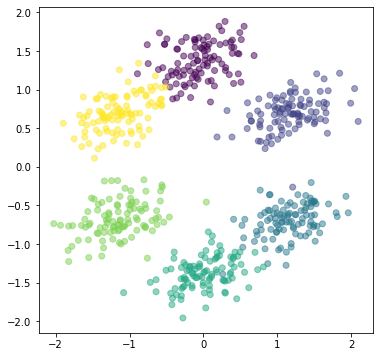

In [33]:
plt.figure(figsize=(6,6))
plt.scatter(dataset['x'], dataset['y'], c=dataset['c'], alpha=0.5)


### Testowanie parametru *width* - szerokości sąsiedztwa

t = 0.1 v-measure = 0.9409824020277223
t = 0.2 v-measure = 0.9397808837720194
t = 0.5 v-measure = 0.9504535337473433
t = 1 v-measure = 0.9464843697234184


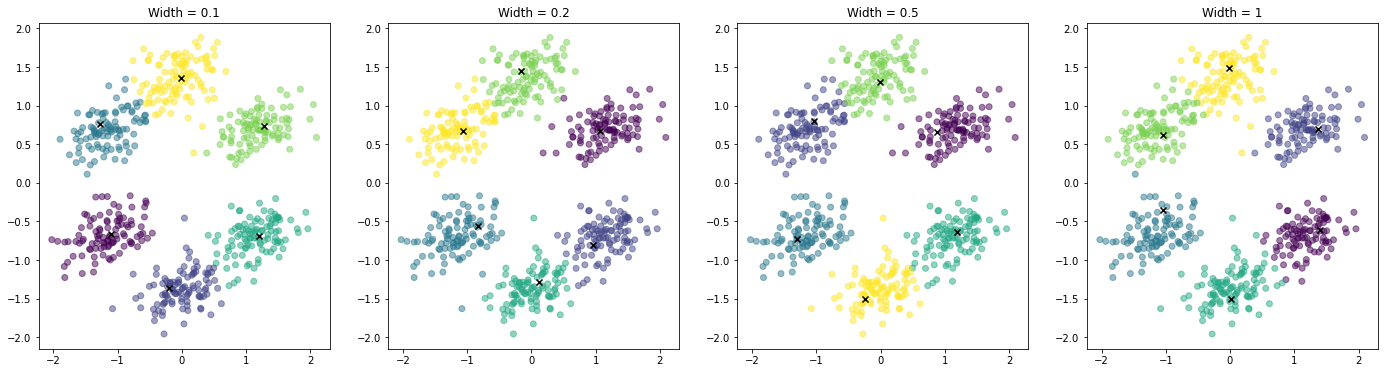

In [15]:
ts = [0.1, 0.2, 0.5, 1]
N, M = 2, 3

fig = plt.figure(figsize=(6*4,6))

for i,t in enumerate(ts):
    koh = KohonenNetwork(N=N, M=M, dataset=x, width=t, architecture='rectangle')
    koh.train(lambda_=100, method='gauss')
    c = koh.classify()

    plt.subplot(1,4,i+1)
    plt.scatter(dataset['x'], dataset['y'], c=c, alpha=0.5)
    plt.scatter(koh.neurons[:,0], koh.neurons[:,1], color = 'black', marker='x')
    plt.title(f'Width = {t}')

    print('t =', t, 'v-measure =', metrics.v_measure_score(labels, c))


t = 0.1 v-measure = 0.8498533900055362
t = 0.2 v-measure = 0.8617361977285001
t = 0.5 v-measure = 0.843753774806606
t = 1 v-measure = 0.8379780894253558


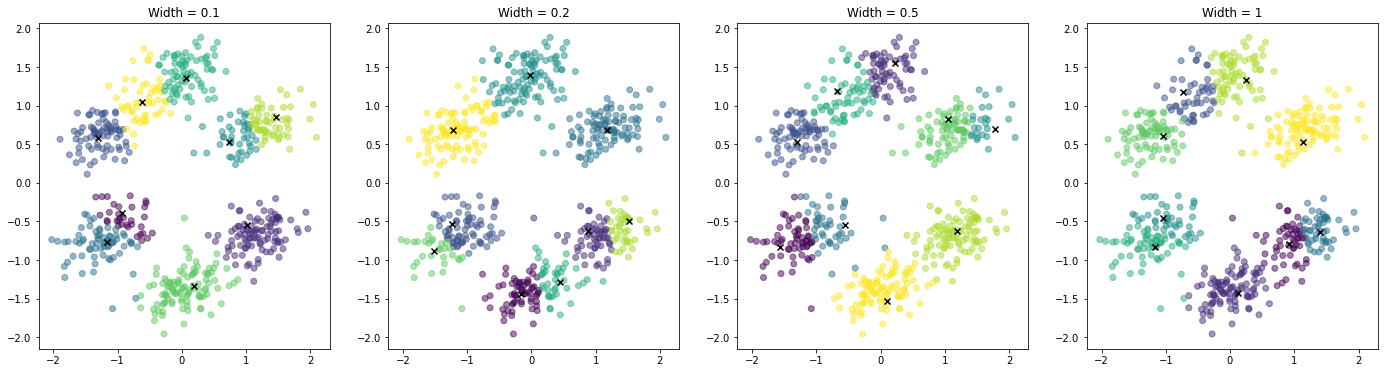

In [16]:
ts = [0.1, 0.2, 0.5, 1]
N, M = 3, 3

fig = plt.figure(figsize=(6*4,6))

for i,t in enumerate(ts):
    koh = KohonenNetwork(N=N, M=M, dataset=x, width=t, architecture='rectangle')
    koh.train(lambda_=100, method='gauss')
    c = koh.classify()

    plt.subplot(1,4,i+1)
    plt.scatter(dataset['x'], dataset['y'], c=c, alpha=0.5)
    plt.scatter(koh.neurons[:,0], koh.neurons[:,1], color = 'black', marker='x')
    plt.title(f'Width = {t}')

    print('t =', t, 'v-measure =', metrics.v_measure_score(labels, c))


t = 0.1 v-measure = 0.7625644948008221
t = 0.2 v-measure = 0.7655535671125846
t = 0.5 v-measure = 0.758934932475861
t = 1 v-measure = 0.7594712982986773


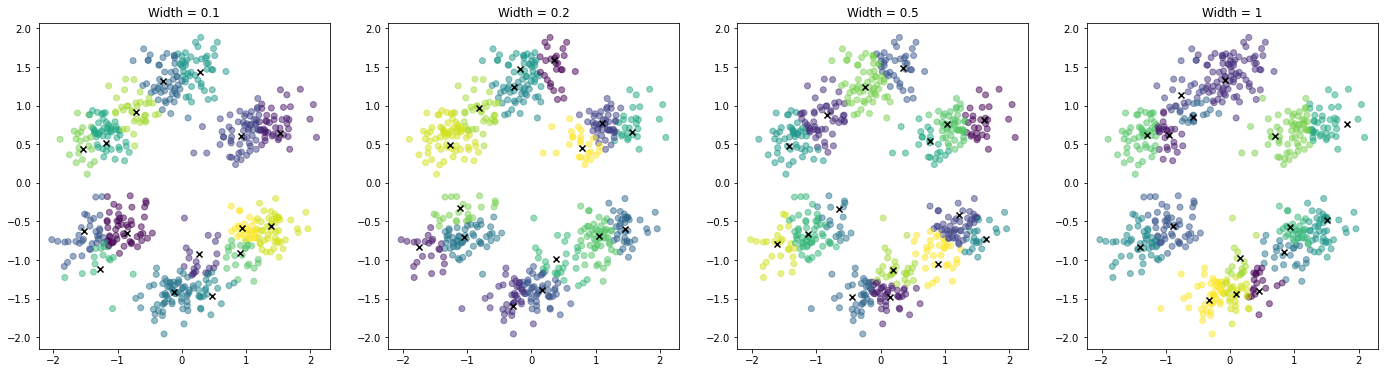

In [13]:
ts = [0.1, 0.2, 0.5, 1]
N, M = 4, 4

fig = plt.figure(figsize=(6*4,6))

for i,t in enumerate(ts):
    koh = KohonenNetwork(N=N, M=M, dataset=x, width=t, architecture='rectangle')
    koh.train(lambda_=100, method='gauss')
    c = koh.classify()

    plt.subplot(1,4,i+1)
    plt.scatter(dataset['x'], dataset['y'], c=c, alpha=0.5)
    plt.scatter(koh.neurons[:,0], koh.neurons[:,1], color = 'black', marker='x')
    plt.title(f'Width = {t}')

    print('t =', t, 'v-measure =', metrics.v_measure_score(labels, c))


### Mexican hat - funkcja gaussowska minus jej druga pochodna

t = 0.1 v-measure = 0.7916334693605546
t = 0.2 v-measure = 0.8754800490926206
t = 0.5 v-measure = 0.8829554610069533
t = 1 v-measure = 0.9305329371848784


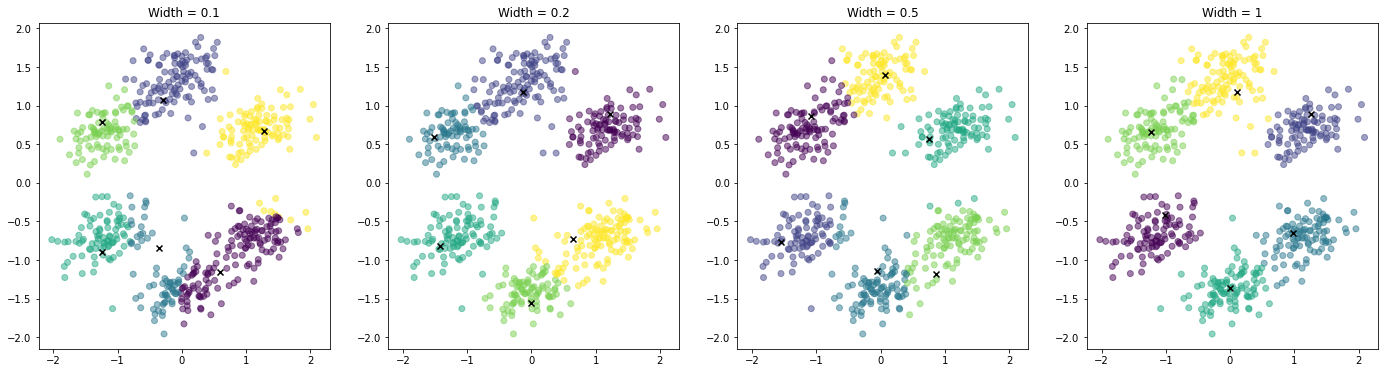

In [19]:
ts = [0.1, 0.2, 0.5, 1]
N, M = 2, 3

fig = plt.figure(figsize=(6*4,6))

for i,t in enumerate(ts):
    koh = KohonenNetwork(N=N, M=M, dataset=x, width=t, architecture='rectangle')
    koh.train(lambda_=100, method='mexican')
    c = koh.classify()

    plt.subplot(1,4,i+1)
    plt.scatter(dataset['x'], dataset['y'], c=c, alpha=0.5)
    plt.scatter(koh.neurons[:,0], koh.neurons[:,1], color = 'black', marker='x')
    plt.title(f'Width = {t}')

    print('t =', t, 'v-measure =', metrics.v_measure_score(labels, c))


t = 0.1 v-measure = 0.833554378668102
t = 0.2 v-measure = 0.7590886621713382
t = 0.5 v-measure = 0.7495548529173155
t = 1 v-measure = 0.8415203507524996


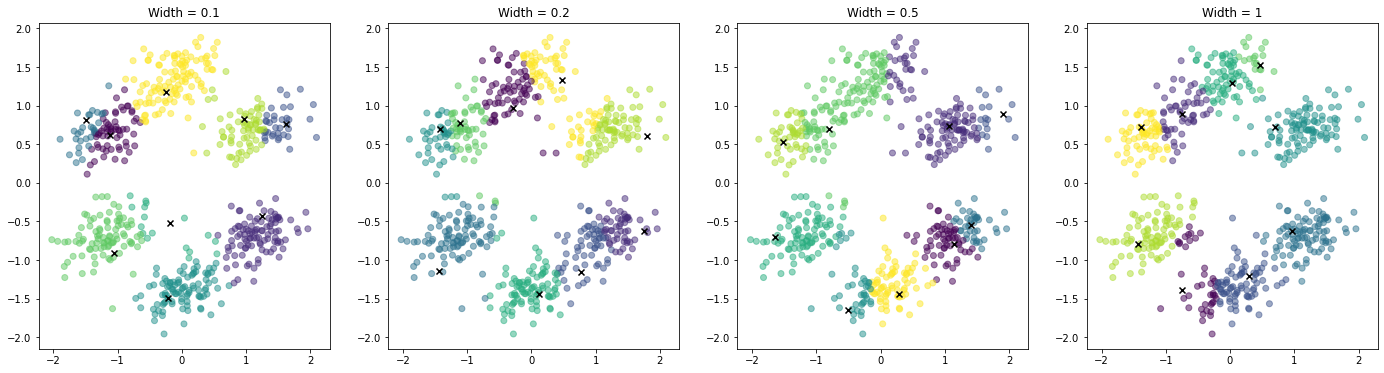

In [18]:
ts = [0.1, 0.2, 0.5, 1]
N, M = 3, 3

fig = plt.figure(figsize=(6*4,6))

for i,t in enumerate(ts):
    koh = KohonenNetwork(N=N, M=M, dataset=x, width=t, architecture='rectangle')
    koh.train(lambda_=100, method='mexican')
    c = koh.classify()

    plt.subplot(1,4,i+1)
    plt.scatter(dataset['x'], dataset['y'], c=c, alpha=0.5)
    plt.scatter(koh.neurons[:,0], koh.neurons[:,1], color = 'black', marker='x')
    plt.title(f'Width = {t}')

    print('t =', t, 'v-measure =', metrics.v_measure_score(labels, c))


t = 0.1 v-measure = 0.7284471046955698
t = 0.2 v-measure = 0.7606899391495549
t = 0.5 v-measure = 0.7510300713477697
t = 1 v-measure = 0.768185511661167


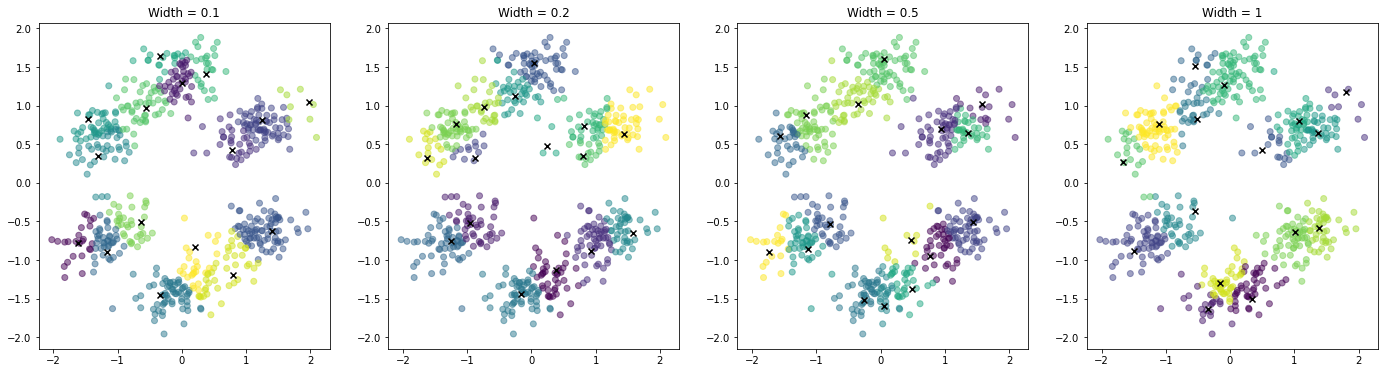

In [14]:
ts = [0.1, 0.2, 0.5, 1]
N, M = 4, 4

fig = plt.figure(figsize=(6*4,6))

for i,t in enumerate(ts):
    koh = KohonenNetwork(N=N, M=M, dataset=x, width=t, architecture='rectangle')
    koh.train(lambda_=100, method='mexican')
    c = koh.classify()

    plt.subplot(1,4,i+1)
    plt.scatter(dataset['x'], dataset['y'], c=c, alpha=0.5)
    plt.scatter(koh.neurons[:,0], koh.neurons[:,1], color = 'black', marker='x')
    plt.title(f'Width = {t}')

    print('t =', t, 'v-measure =', metrics.v_measure_score(labels, c))


## Zbiór danych *Cube*

In [24]:
dataset = pd.read_csv('cube.csv')
x = np.asarray(dataset.iloc[:,[0,1,2]])
labels = dataset['c']

C:\Users\laura\AppData\Local\Temp\ipykernel_3688\1943118584.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


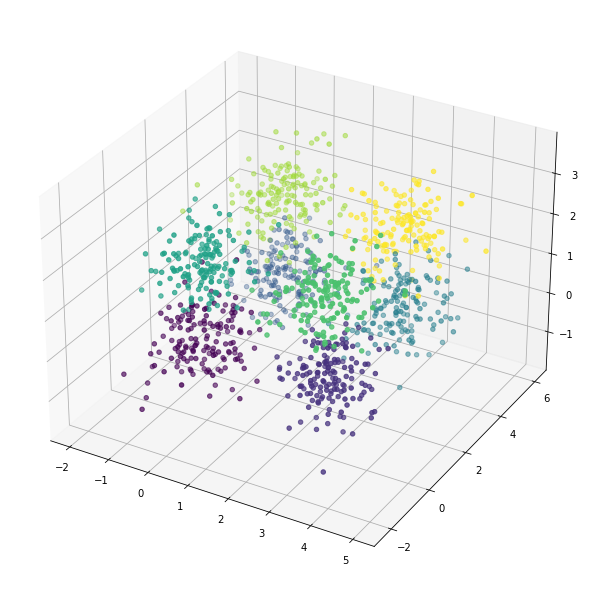

In [25]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.scatter(dataset['x'], dataset['y'], dataset['z'], c=labels)

### Funkcja Gaussa

C:\Users\laura\AppData\Local\Temp\ipykernel_3688\507798898.py:10: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


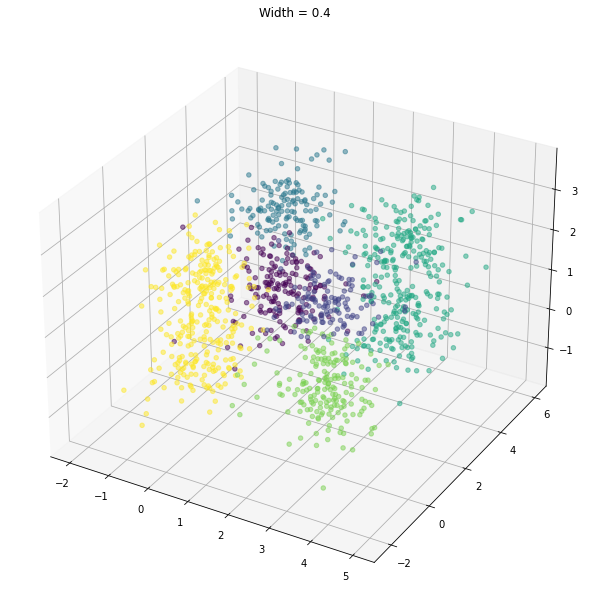

t = 0.4 v-measure = 0.7925830840564464


C:\Users\laura\AppData\Local\Temp\ipykernel_3688\507798898.py:10: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


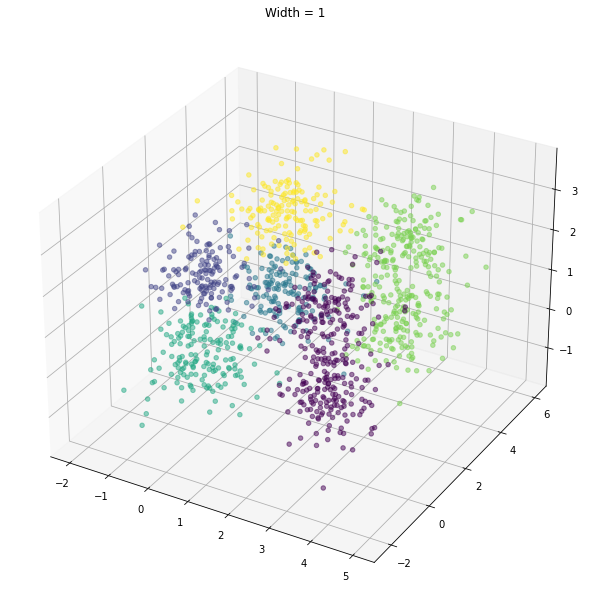

t = 1 v-measure = 0.8274232440024774


In [27]:
ts = [0.4, 1]
N, M = 2, 3

for i,t in enumerate(ts):
    koh = KohonenNetwork(N=N, M=M, dataset=x, width=t, architecture='rectangle')
    koh.train(lambda_=100, method='gauss')
    c = koh.classify()

    fig = plt.figure(figsize=(8,8))
    ax = Axes3D(fig)
    ax.scatter(dataset['x'], dataset['y'], dataset['z'], c=c, alpha=0.5)
    plt.title(f'Width = {t}')
    plt.show()

    print('t =', t, 'v-measure =', metrics.v_measure_score(labels, c))


C:\Users\laura\AppData\Local\Temp\ipykernel_3688\1900036725.py:10: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


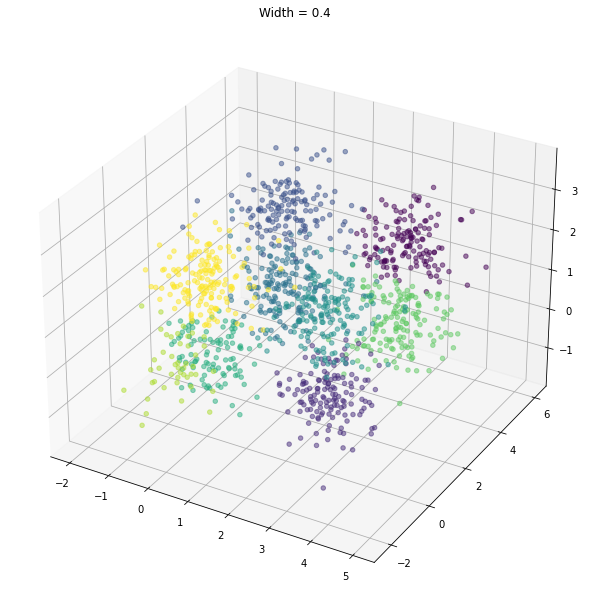

t = 0.4 v-measure = 0.8660759737024032


C:\Users\laura\AppData\Local\Temp\ipykernel_3688\1900036725.py:10: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


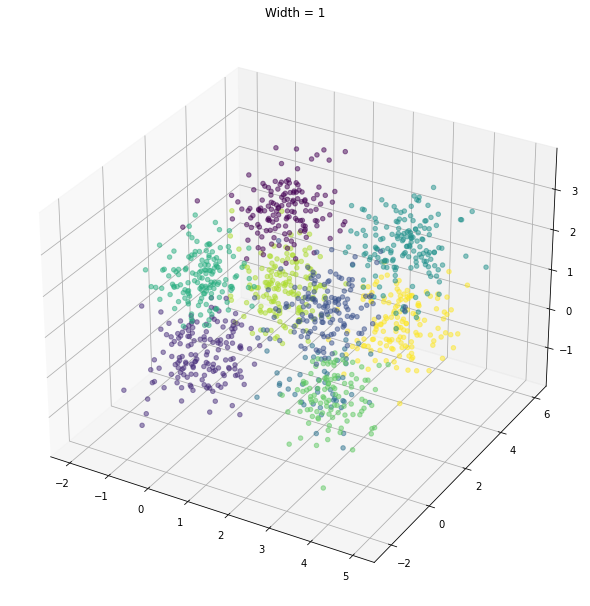

t = 1 v-measure = 0.881666633552133


In [28]:
ts = [0.4, 1]
N, M = 3, 3

for i,t in enumerate(ts):
    koh = KohonenNetwork(N=N, M=M, dataset=x, width=t, architecture='rectangle')
    koh.train(lambda_=100, method='gauss')
    c = koh.classify()

    fig = plt.figure(figsize=(8,8))
    ax = Axes3D(fig)
    ax.scatter(dataset['x'], dataset['y'], dataset['z'], c=c, alpha=0.5)
    plt.title(f'Width = {t}')
    plt.show()

    print('t =', t, 'v-measure =', metrics.v_measure_score(labels, c))


### Mexican hat

C:\Users\laura\AppData\Local\Temp\ipykernel_3688\2217891929.py:10: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


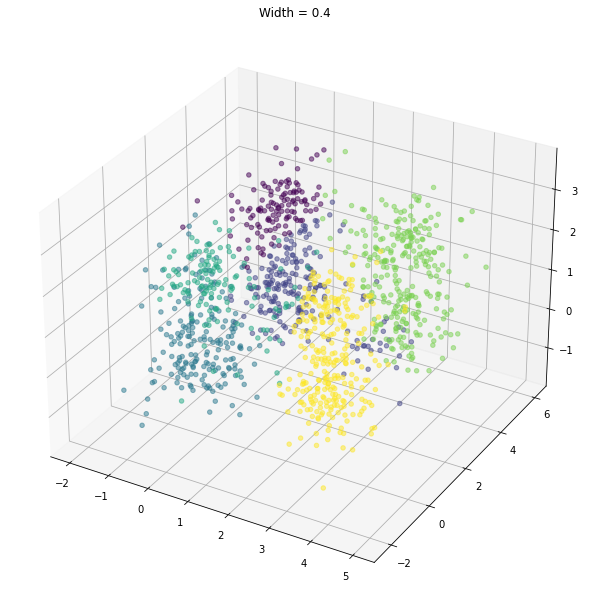

t = 0.4 v-measure = 0.7417173288387344


C:\Users\laura\AppData\Local\Temp\ipykernel_3688\2217891929.py:10: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


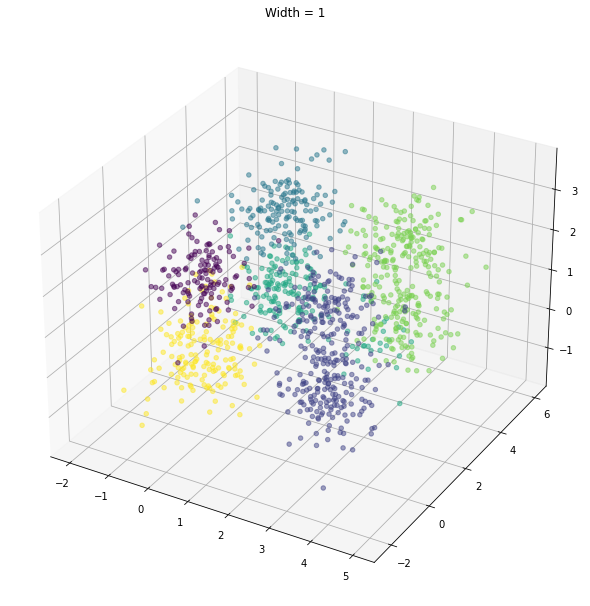

t = 1 v-measure = 0.8136519966911946


In [30]:
ts = [0.4, 1]
N, M = 2, 3

for i,t in enumerate(ts):
    koh = KohonenNetwork(N=N, M=M, dataset=x, width=t, architecture='rectangle')
    koh.train(lambda_=100, method='mexican')
    c = koh.classify()

    fig = plt.figure(figsize=(8,8))
    ax = Axes3D(fig)
    ax.scatter(dataset['x'], dataset['y'], dataset['z'], c=c, alpha=0.5)
    plt.title(f'Width = {t}')
    plt.show()

    print('t =', t, 'v-measure =', metrics.v_measure_score(labels, c))


C:\Users\laura\AppData\Local\Temp\ipykernel_3688\2034369212.py:10: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


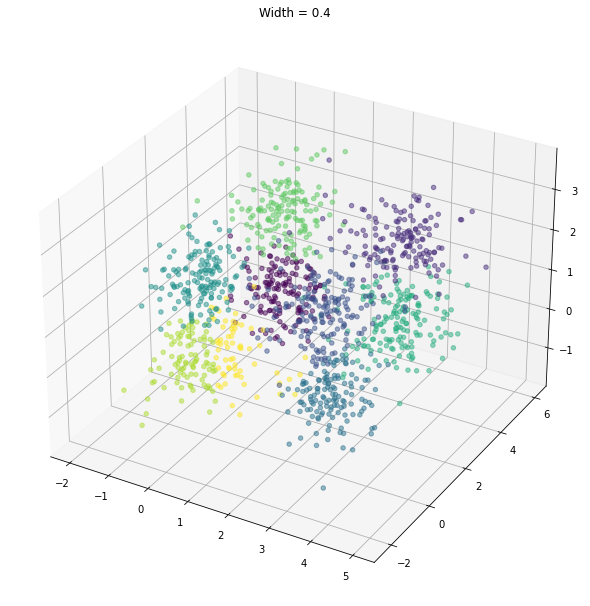

t = 0.4 v-measure = 0.8527620720769093


C:\Users\laura\AppData\Local\Temp\ipykernel_3688\2034369212.py:10: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


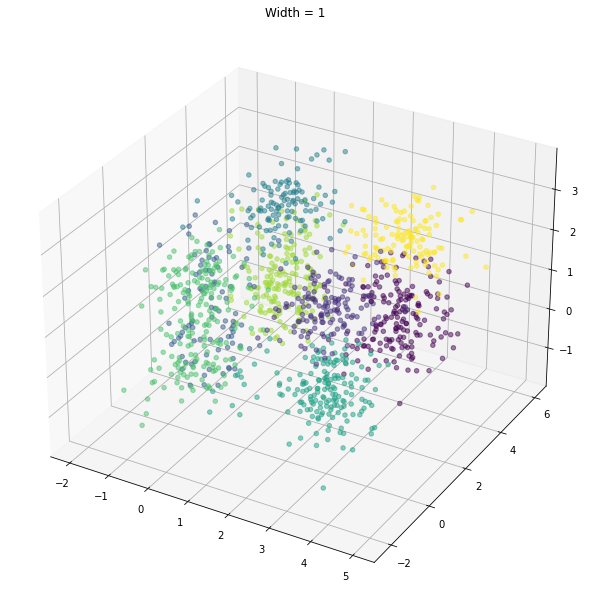

t = 1 v-measure = 0.806132429665689


In [31]:
ts = [0.4, 1]
N, M = 3, 3

for i,t in enumerate(ts):
    koh = KohonenNetwork(N=N, M=M, dataset=x, width=t, architecture='rectangle')
    koh.train(lambda_=100, method='mexican')
    c = koh.classify()

    fig = plt.figure(figsize=(8,8))
    ax = Axes3D(fig)
    ax.scatter(dataset['x'], dataset['y'], dataset['z'], c=c, alpha=0.5)
    plt.title(f'Width = {t}')
    plt.show()

    print('t =', t, 'v-measure =', metrics.v_measure_score(labels, c))
